In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
conn = sqlite3.connect('Data/football_database.db')

query = "SELECT * FROM Matches"

df_matches = pd.read_sql_query(query, conn)

conn.close()

In [3]:
df_matches

,fixture_id,competition_name,season,home_team,away_team,home_goals,away_goals,match_date,match_time,match_status,home_team_formation,away_team_formation
0,587176,Bundesliga,2020,Bayern Munich,FC Schalke 04,8,0,18.09.2020,20:30,FT,4-2-3-1,4-4-2
1,587177,Bundesliga,2020,Borussia Dortmund,Borussia Monchengladbach,3,0,19.09.2020,18:30,FT,3-4-1-2,3-4-3
2,587178,Bundesliga,2020,RB Leipzig,FSV Mainz 05,3,1,20.09.2020,15:30,FT,3-4-2-1,4-2-3-1
3,587179,Bundesliga,2020,VfL Wolfsburg,Bayer Leverkusen,0,0,20.09.2020,18:00,FT,4-3-3,4-1-4-1
4,587180,Bundesliga,2020,Eintracht Frankfurt,Arminia Bielefeld,1,1,19.09.2020,15:30,FT,3-4-1-2,4-1-4-1
...,...,...,...,...,...,...,...,...,...,...,...,...
4281,882138,Serie A,2022,Udinese,Lazio,0,1,21.05.2023,20:45,FT,None,None
4282,882139,Serie A,2022,Sassuolo,Monza,1,2,19.05.2023,20:45,FT,None,None
4283,882143,Serie A,2022,Salernitana,Udinese,0,0,27.05.2023,15:00,1H,None,None
4284,882144,Serie A,2022,Sampdoria,Sassuolo,2,2,26.05.2023,20:45,FT,None,None


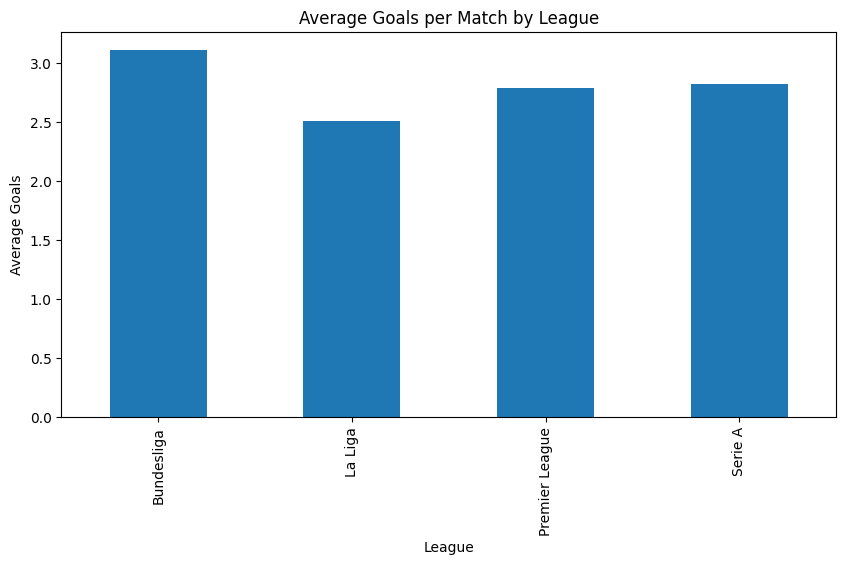

In [4]:
# Calculate the total goals scored per match, then group by competition_name and calculate the mean and plot it

df_matches['total_goals'] = df_matches['home_goals'] + df_matches['away_goals']
avg_goals_per_league = df_matches.groupby('competition_name')['total_goals'].mean()

# Plot
avg_goals_per_league.plot(kind='bar', figsize=(10, 5))
plt.title('Average Goals per Match by League')
plt.ylabel('Average Goals')
plt.xlabel('League')
plt.show()